# Burst and glitches sampler

# Plan
1. generate dataset
    1. create burst waveform (start with Sine-Gaussian toy model)
    2. plug it in `LISAInstrument` and simulate it

    OR
    
    3. do it with `fastlisaresponse`

2. plug it in `lisaanalysistools` `AnalysisContainer`
3. set up Eryn sampler

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In [3]:
import matplotlib as mpl
# Set up plot style for all plots in the notebook
mpl.rcParams.update({'axes.grid' : True,
                     'figure.figsize': [10, 5]})
# mpl.rcParams.items

## Define Sine gaussian burst with sky localization parameters

In [4]:
def SineGaussianBurst(A, f0, phi0, sigma, t0, t, **kwargs):
    """
    A Sine-Gaussian function with 5 parameters.
    
    Inputs:
     - A:     sine amplitude
     - f0:    sine central frequency
     - phi0:  sine intial phase
     - sigma: gaussian width
     - t0:    gaussian central time
     - t:     time

    Return:
     - Sine-Gaussian
    """
    S = A*np.cos(phi0 + 2*np.pi*f0*(t - t0))
    G = np.exp(- (t - t0)**2 / (2*sigma**2))
    
    return S*G


def periodic_SineGaussianBurst(glitch_param_list, t, period):
    """
    Sum multiple Sine-Gaussian functions with 5 parameters.
    Calls the `SineGaussian` function.
    
    Inputs:
     - glitch_param_list: list of glitch parameter lists
     - t:                 time

    Return:
     - Summed Sine-Gaussian
    """
    template = SineGaussianBurst(*glitch_param_list, t)

    reps = t[-1]/period
    print(reps)
    
    for k in range(1,np.int64(reps)):
        # First make sure there are no NaNs in the array!
        template += SineGaussianBurst(*glitch_param_list, t-k*period) + SineGaussianBurst(*glitch_param_list, t+k*period)
    return template

(9990.0, 10010.0)

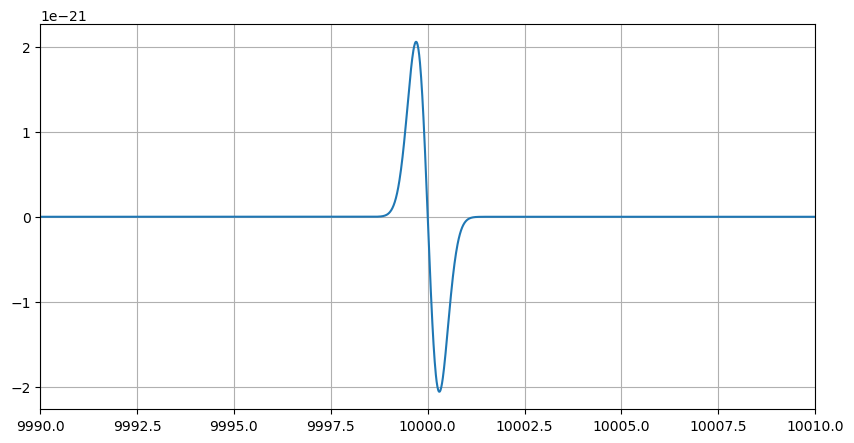

In [38]:
dt = 0.01

times = np.arange(1000, 12000, dt)

# sgparams = dict(
A = 1e-18 # to get a peak height of 1e-21
f0 = 1.8e-3
phi0 = np.pi/2
sigma = 0.3
t0 = 10000

lamb = np.pi/2
beta = np.pi/3

period = 20
# )

plt.plot(times, SineGaussianBurst(A, f0, phi0, sigma, t0, times))
# plt.plot(times, periodic_SineGaussianBurst([A, f0, phi0, sigma, t0], times, period), ls='--')
plt.xlim([9990,10010])

## Define LISA Response wrapper


In [39]:
# imports
from fastlisaresponse import ResponseWrapper
from lisatools.detector import EqualArmlengthOrbits

In [40]:
# if burst_response:
#     del burst_response 

Tobs = 0.001 # observation time in years
tstart = 5000.0 # start time

# order of the langrangian interpolation
order = 25

# 1st or 2nd or custom (see docs for custom)
tdi_gen = "2nd generation"

tdi_kwargs = dict(
    order=order, tdi=tdi_gen, tdi_chan="XYZ",
)

burst_response = ResponseWrapper(
    waveform_gen = SineGaussianBurst, # it takes a generic waveform generator - can be whatever type of waveform you want
    Tobs = Tobs,
    dt = dt,
    index_lambda = 6,
    index_beta = 7,
    t0 = tstart,
    flip_hx = False,  # set to True if waveform is h+ - ihx
    use_gpu = False,
    remove_sky_coords = True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude = False,
    remove_garbage= False,  # removes the beginning of the signal that has bad information
    orbits = EqualArmlengthOrbits(),
    **tdi_kwargs
)

In [41]:
times = np.arange(0, Tobs * YRSID_SI, dt)

times.shape, SineGaussianBurst(A, f0, phi0, sigma, t0, times).shape


((3155815,), (3155815,))

In [42]:

# call response function and generate the TDI response
tdis = burst_response(A, f0, phi0, sigma, tstart+t0, times, lamb, beta)

In [43]:
tstart/dt

500000.0

(7500.0, 7520.0)

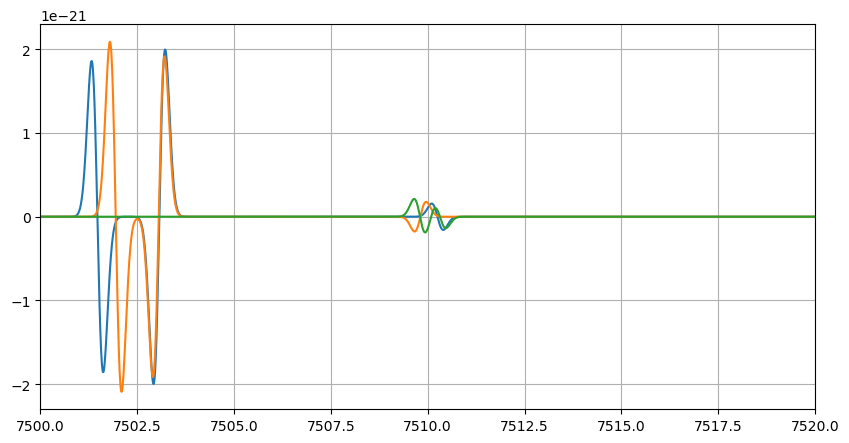

In [74]:
# plt.plot(times[int(tstart/dt)+1:-int(tstart/dt)], tdis[1])

plt.plot(times[1:], tdis[0], label = 'TDI X')
plt.plot(times[1:], tdis[1], label = 'TDI Y')
plt.plot(times[1:], tdis[2], label = 'TDI Z')

# plt.ylim([-1e-22,1e-22])
plt.xlim([7500,7520])

